# EUAir Transport Dataset Experiments

In [1]:
%run codes/utils

In [2]:
from glob import glob
import re
# Progress bar.
from tqdm import tqdm
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
from scipy import stats

The following code block requires

- `#1 Running` **2 minutes and 44 seconds**
- `#2 Running` **3 minutes and 03 seconds**
- `#3 Running` **2 minutes and 44 seconds**

on *Apple MacBook Pro 2021 (M1 Pro Chip and 16 GB Memory)*.

In [3]:
# Grab all subdatasets names into a list of strings.
all_files = glob("datasets/EUAir/LOOCV_subdatasets_EUAir/*")
all_files.sort(key=lambda f: int(re.sub('\D', '', f)))

nodes = len(all_files)
avg_rank = np.zeros(nodes, dtype=float)
# LOOCV_ranking_distribution = []

for subdata in tqdm(all_files):
    sub_network, _, sub_size = loadMultiplex(subdata)
    sub_x, sub_z = stage1(sub_network, sub_size, 1, 1, 1)

    # If the following error has been raised, it means the last node was removed, so the program
    # detected the size of the network (n - 1). Therefore, because the last node does not exist in the
    # current subnetwork, so we need to add a zero as its weight. Note the "last" node could be removed
    # sometimes in a very low possibility, so we used a "while" loop instead of an "if" statement.
    # ValueError: operands could not be broadcast together with shapes (n,) (n - 1,) (n,)
    while len(sub_x) != nodes:
        sub_x = np.append(sub_x, 0.0)

    sorted_indices = np.argsort(-sub_x)
    V_sub_x = np.empty_like(sorted_indices)
    V_sub_x[sorted_indices] = np.arange(len(sub_x))

    avg_rank += V_sub_x
    # The following statement would generate a 450 * 450 table (list * np.ndarray) to store the result
    # from each iteration in LOOCV.
    # LOOCV_ranking_distribution.append(sub_x)

avg_rank /= nodes
# flatten_ranking = np.concatenate(LOOCV_ranking_distribution).ravel()

100%|█████████████████████████████████████████| 450/450 [02:44<00:00,  2.74it/s]


In [4]:
origin_network, _, origin_size = loadMultiplex("datasets/EUAir/EUAir_Transportation_multiplex.csv")

o_x, o_z = stage1(origin_network, origin_size, 1, 1, 1)
sorted_indices = np.argsort(-o_x)
V_o_x = np.empty_like(sorted_indices)
V_o_x[sorted_indices] = np.arange(len(-o_x))

difference = V_o_x - avg_rank
abs_difference = abs(difference)
percentage_diff = difference / len(difference)

## Compare the Difference between one-time Results and LOOCV Results

In [5]:
Ncount = 0
Pcount = 0
Zcount = 0
k = 0.005383
for val in percentage_diff:
    if val >= -k and val < 0:
        Ncount += 1
    elif val <= k and val > 0:
        Pcount += 1
    elif val == 0:
        Zcount += 1
count = Ncount + Pcount + Zcount
print("Negative: %d" %(Ncount))
print("Zero: %d" %(Zcount))
print("Positive: %d" %(Pcount))
print("There are %.2f%% nodes have a less than %.3f%% difference with LOOCV result." %(count / len(percentage_diff) * 100, k * 100))
Vline_95_left = -Ncount - Zcount // 2
Vline_95_right = Pcount + Zcount // 2
print("Left line should be located at x = %d" %(Vline_95_left))
print("Right line should be located at x = %d" %(Vline_95_right))

Negative: 267
Zero: 3
Positive: 158
There are 95.11% nodes have a less than 0.538% difference with LOOCV result.
Left line should be located at x = -268
Right line should be located at x = 159


In [6]:
betw_centra = s1_betweenness_centrality(origin_network, origin_size)
clos_centra = s1_closeness_centrality(origin_network, origin_size)
degr_centra = s1_degree_centrality(origin_network, origin_size)
eige_centra = s1_eigenvector_centrality(origin_network, origin_size)
rho_betw, p_betw = stats.spearmanr(o_x, betw_centra)
rho_clos, p_clos = stats.spearmanr(o_x, clos_centra)
rho_degr, p_degr = stats.spearmanr(o_x, degr_centra)
rho_eige, p_eige = stats.spearmanr(o_x, eige_centra)

## Spearman's Rank Correlation Coefficient to Demonstrate the Robustness

In [7]:
# Spearman's rank correlation coefficient between our
# results and networkx **betweenness** centralities.
rho_betw, p_betw

(0.8640157764513703, 1.3223502568148643e-135)

In [8]:
# Spearman's rank correlation coefficient between our
# results and networkx **closeness** centralities.
rho_clos, p_clos

(0.8673213271066078, 7.908259029280741e-138)

In [9]:
# Spearman's rank correlation coefficient between our
# results and networkx **degree** centralities.
rho_degr, p_degr

(0.9964455410340898, 0.0)

In [10]:
# Spearman's rank correlation coefficient between our
# results and networkx **eigenvector** centralities.
rho_eige, p_eige

(0.9225156885128195, 2.4080108581048014e-187)

## Compare with Other Methods

### Betweenness Centrality

The following code block requires

- `#1 Running` **8 minutes and 20 seconds**
- `#2 Running` **8 minutes and 26 seconds**
- `#3 Running` **7 minutes and 58 seconds**

on *Apple MacBook Pro 2021 (M1 Pro Chip and 16 GB Memory)*.

In [11]:
# Using all_files from part 1.

nodes = len(all_files)
b_avg_rank = np.zeros(nodes, dtype=float)

for subdata in tqdm(all_files):
    sub_network, _, sub_size = loadMultiplex(subdata)
    b_sub_x = s1_betweenness_centrality(sub_network, sub_size)

    while len(b_sub_x) != nodes:
        b_sub_x = np.append(b_sub_x, 0.0)

    b_sorted_indices = np.argsort(-b_sub_x)
    b_V_sub_x = np.empty_like(b_sorted_indices)
    b_V_sub_x[b_sorted_indices] = np.arange(len(b_sub_x))
    b_avg_rank += b_V_sub_x

b_avg_rank /= nodes

100%|█████████████████████████████████████████| 450/450 [07:58<00:00,  1.06s/it]


In [12]:
b_o_x = s1_betweenness_centrality(origin_network, origin_size)
b_sorted_indices = np.argsort(-b_o_x)
b_V_o_x = np.empty_like(b_sorted_indices)
b_V_o_x[b_sorted_indices] = np.arange(len(-b_o_x))

b_difference = b_V_o_x - b_avg_rank
b_abs_difference = abs(b_difference)
b_percentage_diff = b_difference / len(b_difference)

### Closeness Centrality

The following code block requires

- `#1 Running` **4 minutes and 10 seconds**
- `#2 Running` **3 minutes and 42 seconds**
- `#3 Running` **3 minutes and 37 seconds**

on *Apple MacBook Pro 2021 (M1 Pro Chip and 16 GB Memory)*.

In [13]:
# Using all_files from part 1.

nodes = len(all_files)
c_avg_rank = np.zeros(nodes, dtype=float)

for subdata in tqdm(all_files):
    sub_network, _, sub_size = loadMultiplex(subdata)
    c_sub_x = s1_closeness_centrality(sub_network, sub_size)

    while len(c_sub_x) != nodes:
        c_sub_x = np.append(c_sub_x, 0.0)

    c_sorted_indices = np.argsort(-c_sub_x)
    c_V_sub_x = np.empty_like(c_sorted_indices)
    c_V_sub_x[c_sorted_indices] = np.arange(len(c_sub_x))
    c_avg_rank += c_V_sub_x

c_avg_rank /= nodes

100%|█████████████████████████████████████████| 450/450 [03:37<00:00,  2.06it/s]


In [14]:
c_o_x = s1_closeness_centrality(origin_network, origin_size)
c_sorted_indices = np.argsort(-c_o_x)
c_V_o_x = np.empty_like(c_sorted_indices)
c_V_o_x[c_sorted_indices] = np.arange(len(-c_o_x))

c_difference = c_V_o_x - c_avg_rank
c_abs_difference = abs(c_difference)
c_percentage_diff = c_difference / len(c_difference)

### Degree Centrality

The following code block requires

- `#1 Running` **3 minutes and 10 seconds**
- `#2 Running` **2 minutes and 49 seconds**
- `#3 Running` **2 minutes and 44 seconds**

on *Apple MacBook Pro 2021 (M1 Pro Chip and 16 GB Memory)*.

In [15]:
# Using all_files from part 1.

nodes = len(all_files)
d_avg_rank = np.zeros(nodes, dtype=float)

for subdata in tqdm(all_files):
    sub_network, _, sub_size = loadMultiplex(subdata)
    d_sub_x = s1_degree_centrality(sub_network, sub_size)

    while len(d_sub_x) != nodes:
        d_sub_x = np.append(d_sub_x, 0.0)

    d_sorted_indices = np.argsort(-d_sub_x)
    d_V_sub_x = np.empty_like(d_sorted_indices)
    d_V_sub_x[d_sorted_indices] = np.arange(len(d_sub_x))
    d_avg_rank += d_V_sub_x

d_avg_rank /= nodes

100%|█████████████████████████████████████████| 450/450 [02:44<00:00,  2.73it/s]


In [16]:
d_o_x = s1_degree_centrality(origin_network, origin_size)
d_sorted_indices = np.argsort(-d_o_x)
d_V_o_x = np.empty_like(d_sorted_indices)
d_V_o_x[d_sorted_indices] = np.arange(len(-d_o_x))

d_difference = d_V_o_x - d_avg_rank
d_abs_difference = abs(d_difference)
d_percentage_diff = d_difference / len(d_difference)

### Eigenvector Centrality

The following code block requires

- `#1 Running` **2 minutes and 58 seconds**
- `#2 Running` **3 minutes and 06 seconds**
- `#3 Running` ** minutes and  seconds**

on *Apple MacBook Pro 2021 (M1 Pro Chip and 16 GB Memory)*.

In [17]:
# Using all_files from part 1.

nodes = len(all_files)
e_avg_rank = np.zeros(nodes, dtype=float)

for subdata in tqdm(all_files):
    sub_network, _, sub_size = loadMultiplex(subdata)
    e_sub_x = s1_eigenvector_centrality(sub_network, sub_size)

    while len(e_sub_x) != nodes:
        e_sub_x = np.append(e_sub_x, 0.0)

    e_sorted_indices = np.argsort(-e_sub_x)
    e_V_sub_x = np.empty_like(e_sorted_indices)
    e_V_sub_x[e_sorted_indices] = np.arange(len(e_sub_x))
    e_avg_rank += e_V_sub_x

e_avg_rank /= nodes

100%|█████████████████████████████████████████| 450/450 [03:03<00:00,  2.46it/s]


In [18]:
e_o_x = s1_eigenvector_centrality(origin_network, origin_size)
e_sorted_indices = np.argsort(-e_o_x)
e_V_o_x = np.empty_like(e_sorted_indices)
e_V_o_x[e_sorted_indices] = np.arange(len(-e_o_x))

e_difference = e_V_o_x - e_avg_rank
e_abs_difference = abs(e_difference)
e_percentage_diff = e_difference / len(e_difference)

## Figures Drawing

In [19]:
%config InlineBackend.figure_format = 'retina'

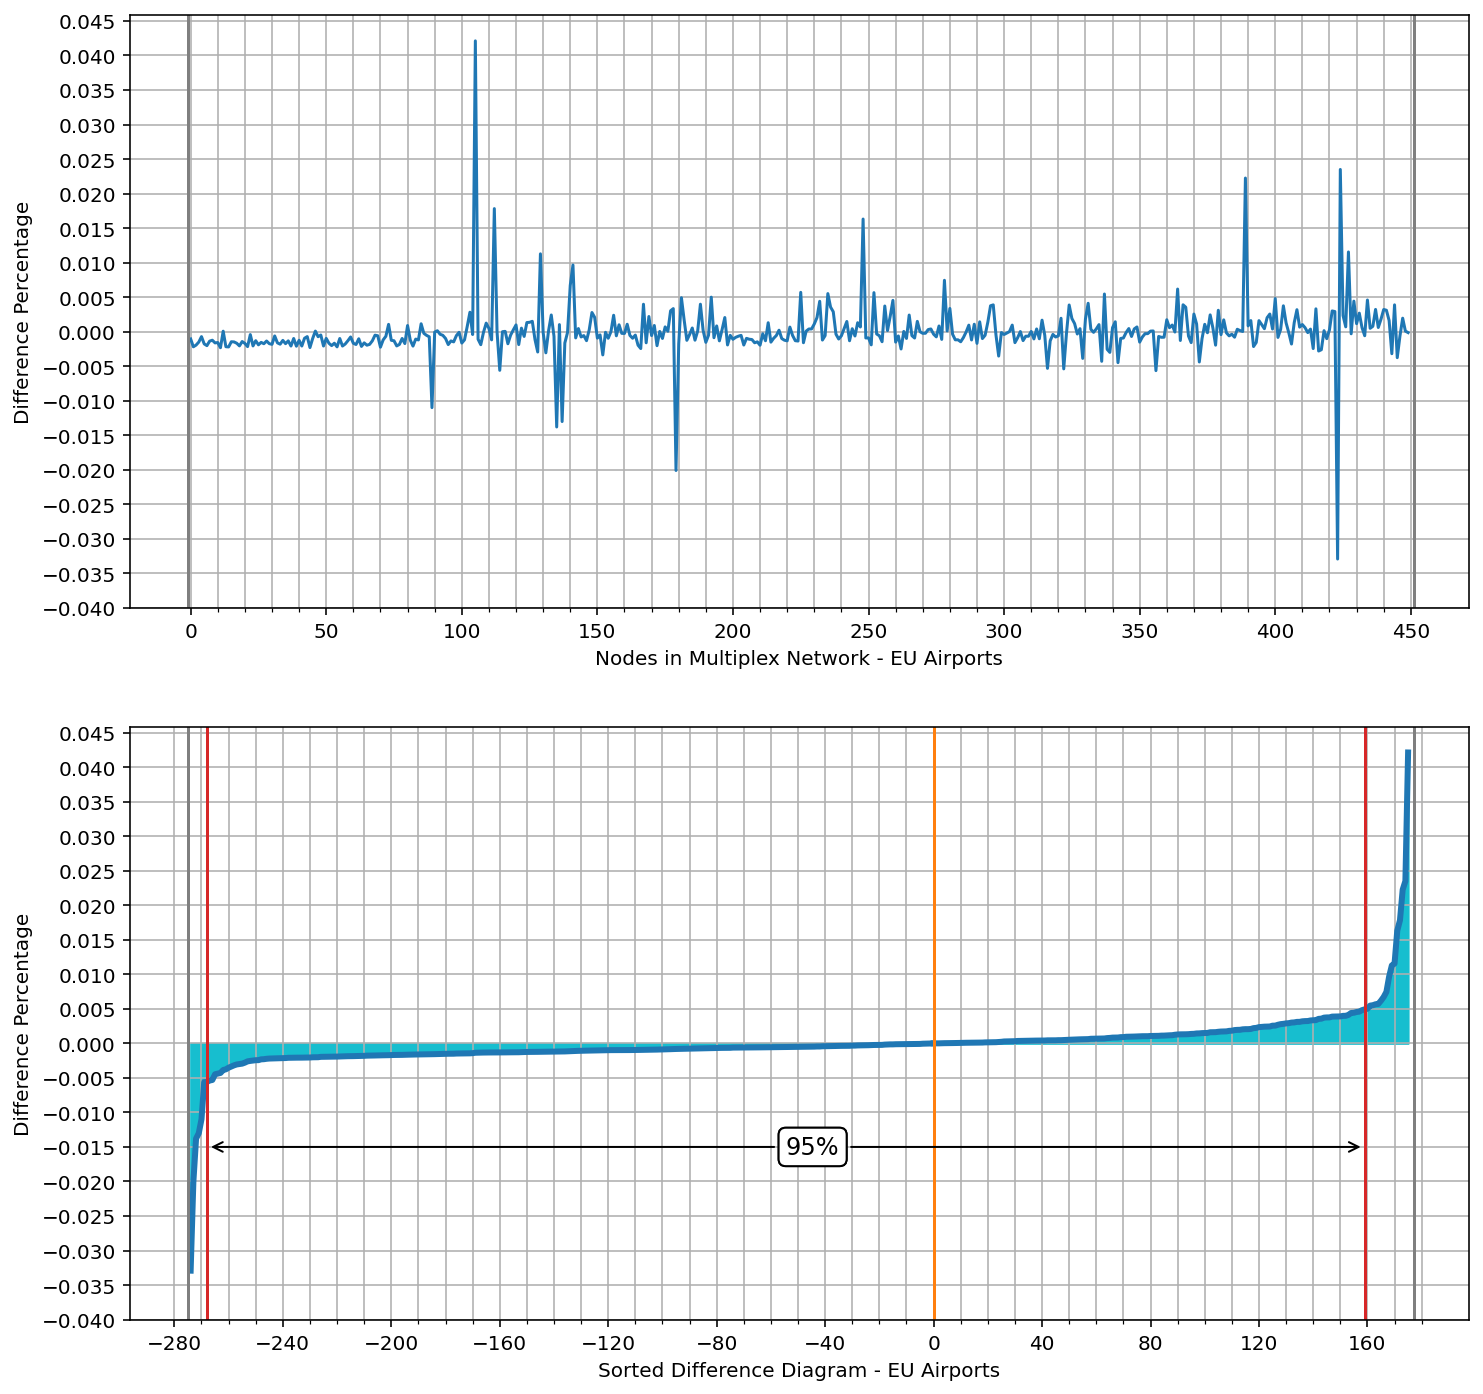

In [20]:
# Figure 1: Unsorted Differece

fig, (us, s) = plt.subplots(2, 1, figsize=(12, 12))

sort = sorted(percentage_diff)
x_axis = np.arange(0.0, 450.0, 1.0)

# Major ticks every 50, minor ticks every 10
major_ticks = np.arange(0, 451, 50)
minor_ticks = np.arange(0, 451, 10)

# Major y ticks every 0.005, minor y ticks every 0.001
major_y_ticks = np.arange(-0.04, 0.05, 0.005)
minor_y_ticks = np.arange(-0.04, 0.05, 0.001)

us.plot(x_axis, percentage_diff)
# us.stem(x_axis, percentage_diff)
us.axvline(x=-1, color='C7')
us.axvline(x=451, color='C7')
us.set_xlabel('Nodes in Multiplex Network - EU Airports')
us.set_ylabel('Difference Percentage')
us.set_xticks(major_ticks)
us.set_xticks(minor_ticks, minor=True)
us.set_yticks(major_y_ticks)

# And a corresponding grid
us.grid(which='both')

################################################################################

# Figure 2: Sorted Differece

positive = [ele for ele in sort if ele >= 0]
negative = [ele for ele in sort if ele < 0]
x_p = np.arange(0, len(positive), 1.0)
x_n = np.arange(-len(negative), 0, 1.0)
x_axis_sort = np.arange(-len(negative), len(positive), 1.0)

# Major x ticks every 40, minor x ticks every 10
major_sort_ticks = np.concatenate((np.arange(-280, 0, 40), np.arange(0, 181, 40)))
minor_sort_ticks = np.concatenate((np.arange(-280, 0, 10), np.arange(0, 181, 10)))

s.plot(x_p, positive, color='C0', linewidth=3)
s.plot(x_n, negative, color='C0', linewidth=3)
s.fill_between(x_axis_sort, 0, sort, color='C9')
s.axvline(x=0, color='C1')
s.axvline(x=Vline_95_left, color='C3')
s.axvline(x=Vline_95_right, color='C3')
s.axvline(x=-len(negative) - 1, color='C7')
s.axvline(x=len(positive) + 1, color='C7')
s.set_xlabel('Sorted Difference Diagram - EU Airports')
s.set_ylabel('Difference Percentage')

# Annotation

s.annotate(
    '95%',
    xy=(Vline_95_left, -0.015), xycoords='data', color='white',
    xytext=((Vline_95_left + Vline_95_right) / 2, -0.015), textcoords='data',
    va="center", ha="left", size=12,
    bbox=dict(boxstyle="round", fc="w"),
    arrowprops=dict(arrowstyle="->"))
s.annotate(
    '95%',
    xy=(Vline_95_right, -0.015), xycoords='data',
    xytext=((Vline_95_left + Vline_95_right) / 2, -0.015), textcoords='data',
    va="center", ha="left", size=12,
    bbox=dict(boxstyle="round", fc="w"),
    arrowprops=dict(arrowstyle="->"))

s.set_xticks(major_sort_ticks)
s.set_xticks(minor_sort_ticks, minor=True)
s.set_yticks(major_y_ticks)

s.grid(which='both')

fig.savefig("docs/img/Result_s1_EUAir.eps", format='eps', bbox_inches='tight')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


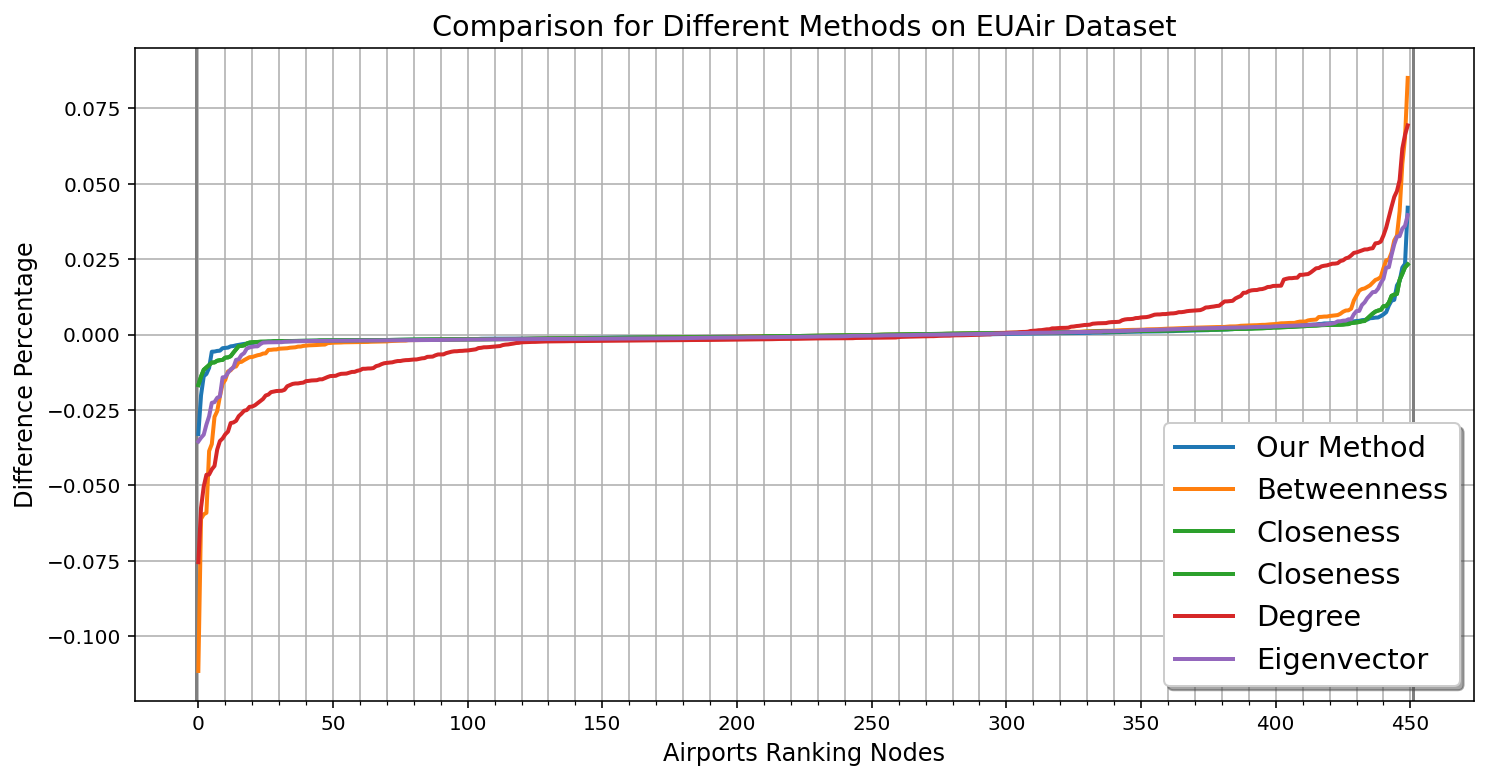

In [21]:
# Figure 3: Comparision Our Method with Other Algorithms
# Sorted Data for Plotting
ours = sort
betw = sorted(b_percentage_diff)
clos = sorted(c_percentage_diff)
degr = sorted(d_percentage_diff)
eige = sorted(e_percentage_diff)

fig, ax = plt.subplots(figsize=(12, 6))

# Major ticks every 50, minor ticks every 10
major_ticks = np.arange(0, 451, 50)
minor_ticks = np.arange(0, 451, 10)

x_axis = np.arange(0.0, 450.0, 1.0)

ax.axvline(x=-1, color='C7')
ax.axvline(x=451, color='C7')

ax.plot(x_axis, ours, color='C0', linewidth=2, label="Our Method")
ax.plot(x_axis, betw, color='C1', linewidth=2, label="Betweenness")
ax.plot(x_axis, clos, color='C2', linewidth=2, label="Closeness")
ax.plot(x_axis, clos, color='C2', linewidth=2, label="Closeness")
ax.plot(x_axis, degr, color='C3', linewidth=2, label="Degree")
ax.plot(x_axis, eige, color='C4', linewidth=2, label="Eigenvector")

ax.set_xlabel('Airports Ranking Nodes', fontsize='large')
ax.set_ylabel('Difference Percentage', fontsize='large')
ax.set_title('Comparison for Different Methods on EUAir Dataset', fontsize='x-large')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.legend(fontsize="x-large", loc='lower right', shadow=True, fancybox=True)

fig.savefig("docs/img/Result_s1_EUAir_comparison.eps", format='eps', bbox_inches='tight')

plt.show()